This script will show you how to read frames from a video, resize it and sample sub-images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
def sample_image(img, x, y, win_size, cnn_size):
  h, w, = img.shape

  delta = int(win_size/2)

  x0 = x - delta 
  x1 = x + delta
  y0 = y - delta
  y1 = y + delta

  if y0 < 0:
      y0 = int(0)
      y1 = int(win_size * 3)
  
  if y1 > h:
      y0 = int(h - win_size * 3)
      y1 = int(h)
  
  if x0 < 0:
      x0 = int(0)
      x1 = int(win_size * 4)
  
  if x1 > w:
      x0 = int(w - win_size * 4)
      x1 = int(w)

  img_sample = img[y0:y1, x0:x1]

  # convert to CNN format
  img_cnn = cv2.resize(img_sample, (cnn_size,cnn_size))
  img_cnn = cv2.cvtColor(img_cnn,cv2.COLOR_GRAY2RGB)


  return img_cnn, [x0,x1,y0,y1]

In [ ]:
def sample_image_2(img, x0,y0,x1,y1 ,win_size, cnn_size):
  """
  This function allows to get a custom sample for an image
  """

  img_sample = img[x0:y0, x1:y1]
  # convert to CNN format
  img_cnn = cv2.resize(img_sample, (cnn_size,cnn_size))
  img_cnn = cv2.cvtColor(img_cnn,cv2.COLOR_GRAY2RGB)


  return img_cnn, [x0,x1,y0,y1]

In [ ]:
# Use the loaded model to make predictions 
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('/content/drive/My Drive/Module 2/Output-M2-TWIST/image_no_mixed_rocks_classifer_model.h5')
# summarize model.
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 192, 192, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF (None, 192, 192, 3)       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO (None, 192, 192, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
#quantize model 
#Now lets choose the optimzation strategy
import tensorflow as tf
optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY

In [ ]:
#Generate the tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [optimization]
tflite_model = converter.convert()

#Now lets save the TFlite model
with open('rocks_classifier.tflite','wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp9tqtbiyk/assets


In [ ]:
#Time to test the TFlite mode
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

In [ ]:
def prediction_on_lite_model(sample,interpreter,class_names):
  """
  This function allows to perform prediction
  on the lite model 

  parameters : 
  sample (image) : the image to predict
  interperter (interpreter) : the lite model interpreter
  class_names (array): the class names

  returns 
  output_data (array) : the prediction propability 
  """
  sample = sample.reshape(input_shape)
  sample = sample.astype('float32')
  interpreter.set_tensor(input_details[0]['index'],sample)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  return output_data

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

def predict_image(image,model):
  """
  this function allows classify an image

  parameters:
  image (array) : the image to classify
  model (model) : the classifier

  returns:
  result( np array) : the prediction 

  """
  test_image = np.expand_dims(image, axis = 0)
  #predict the result
  result = model.predict(test_image)
  return result


In [ ]:
import pandas as pd
def array_to_dataframe(array):
  """
  this function allows to convert any array to dataframe 

  parameters:
  array (array) : the array to convert

  returns:
  array_df( pd dataframe) : the dataframe

  """
  array_df =  pd.DataFrame(array, columns=['chip', 'fines', 'lump', 'pellets']) 
  return array_df

In [ ]:
import pandas as pd 
from sklearn.ensemble import IsolationForest
def is_changed(db,contamination=.01):
  """
  this function allows to detect any structure changes using Isolation Forest

  parameters:
  df (pd dataframe) : the dataframe to analyze
  contamination (float) : contamination threshold

  returns:
  df( pb dataframe) : the input dataframe with the structure chage analysis
  0 if changes 1 otherwise

  """
  df = db.copy()   
  cols = df.columns.drop('Frame').tolist()
  delta_cols = list()
  for c in cols:
      #Compute the variation of the probability between the classes 
      df['delta_' + c] = abs(df[c].diff()).fillna(0)
      delta_cols.append('delta_' + c)
  #predict variation outlier
  model = IsolationForest(n_estimators=5, random_state=47, contamination=contamination)
  #detect variation peak : 
  df['variation_pick'] = model.fit_predict(df[delta_cols].astype(float))
  return df['variation_pick'].iloc[-1]

In [ ]:
# Filter black screen
def is_sorta_black(arr, threshold=10):
  """
  this function allows to filter the black images : 

   parameters : 
   arr (np array) : image as a numpy arrat
   threshold (int) : threshold 

   returns : 
   bool : True if black images False otherwise

   
  """
    tot = np.float(np.sum(arr))
    if tot/arr.size  > threshold : 
       return False
    else:
       return True

In [ ]:
class_names = ['chip', 'fines', 'lump', 'pellets']

In [93]:
def video_treatment(vid_path):
  """
  this function allows to analyse the video : 
  - build array to get the bin composition
  - decide when notification should be sent

   parameters : 
   vid_path (string) : path to the video 

   returns : 
   pred_df (pandas dataframe): the prediction 
   structure_df (pandas dataframe): the structure change prediction
   pred_frame (np array): array of the video frames 

   
  """
  cap = cv2.VideoCapture(vid_path)
  N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print(N_frames)
  sample_window_size = 100
  cnn_img_size = 192
  pred_df = pd.DataFrame()
  pred_frame = []
  pred_per_frame = []
  # df for storing chrome structure
  structure_df = pd.DataFrame()
  tic = time.process_time()
  count_img = 0
  STEPS = 5
  for frame in range(N_frames):
    has_img, img = cap.read()
    if int(frame/ STEPS) == (frame/ STEPS):
        sample_df = pd.DataFrame()
        if not is_sorta_black(img):
            if has_img:
              count_img +=1
              # Images in your trainging set were monochrome
              img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

              # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
              #sample 1 and 2 from Emile's sampling function 
              y = [300,200]
              x = [300,100]
              for i in range(len(x)):
                sample, rect= sample_image(img_mono, int(x[i]), int(y[i]), sample_window_size, cnn_img_size)
                pred_s = prediction_on_lite_model(sample,interpreter,class_names) #predict using the lite model
                #pred_s = predict_image(sample,model) #predict using the initial model

              #sample 3 and 4 from the cutomized sampling function 
              sample, rect= sample_image_2(img_mono, 150,250, 50,200, sample_window_size, cnn_img_size)
              pred_s = prediction_on_lite_model(sample,interpreter,class_names) #predict using the lite model
              #pred_s = predict_image(sample,model)
              sample_df = sample_df.append(array_to_dataframe(pred_s))

              sample, rect= sample_image_2(img_mono, 230,300, 100,200, sample_window_size, cnn_img_size)
              pred_s = prediction_on_lite_model(sample,interpreter,class_names) #predict using the initial model
              #pred_s = predict_image(sample,model)
              sample_df = sample_df.append(array_to_dataframe(pred_s))
 

              #GET Global Composition
              sample_df['Frame'] = frame
              #Set change to zeros by default can be change if necessary 
              sample_df['change'] = 0
              group_sample_df = sample_df.groupby('Frame').mean().reset_index()
              #Store DataFrame
              structure_df = pd.concat((structure_df, sample_df))
              if count_img > 3:
                  result = is_changed(structure_df) # detect change
                  if result== -1:
                    structure_df['change'].iloc[-1] = 1
                    print("structure change on frame "+ str(frame))
                    plt.imshow(img)
                    plt.show()

              pred_df = pred_df.append(array_to_dataframe(pred_s))
              pred_frame.append(frame) 
  dt = time.process_time() - tic
  print(dt)
  print(dt/count_img) # Samples per frame should be below 150 ms

  return structure_df,pred_df,pred_frame

In [ ]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_1.mp4"
%time
structure,pred_df,pred_frame = video_treatment(vid_path)

In [106]:
pred_df['Frame'] = pred_frame
structure["max_proba"] = structure[class_names].max(1)
notification = structure[structure['change']==1] #get the frames where notifications should have been sent 

In [107]:
pred_df.head()

,chip,fines,lump,pellets,Frame
0,0.000084,0.001668,1.655434e-06,0.998246,0
0,0.000156,0.002379,2.450008e-05,0.997441,5
0,0.000236,0.000504,1.223448e-05,0.999248,10
0,0.000396,0.000396,1.552775e-05,0.999193,15
0,0.000013,0.000018,2.387079e-07,0.999969,20


In [108]:
notification

,chip,fines,lump,pellets,Frame,change,max_proba
0,0.000047,0.001293,0.000003,0.998657,70,1,0.998657
0,0.991100,0.000010,0.008863,0.000028,525,1,0.991100
0,0.984035,0.000030,0.015883,0.000052,530,1,0.984035
0,0.952413,0.000027,0.047469,0.000091,535,1,0.952413
0,0.549463,0.442689,0.005249,0.002599,550,1,0.549463


In [ ]:
xticks=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500]

In [110]:
def plot_bin_composition(pred_df,notification):
  """
  This function allows to plot the in composition 
  and indicate where the notification should have been sent

  parameters: 
  pred_df (pd dataframe) :  dataframe containing the composition percentage
  notification (pd dataframe ) : dataframe containing the notification frame
  """
  ax = pred_df.plot.area(x='Frame',figsize=(20, 5),xticks=xticks)
  ax.set_ylabel("Composition [%]")
  ax.set_xlabel("Frame Number")
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  for frame in notification['Frame']:
    ax = plt.axvline(linewidth=4,x=frame, ymin=0.05, ymax=0.983436, color='b', label='axvline - % of full height')
  

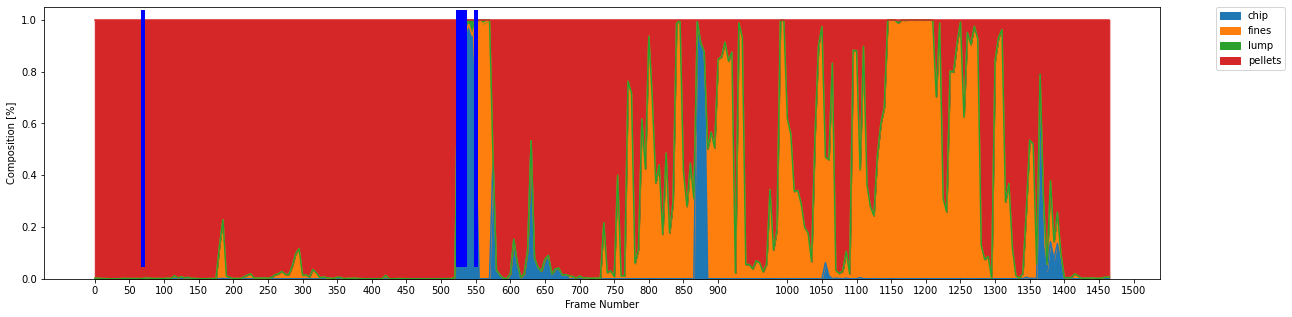

In [111]:
plot_bin_composition(pred_df,notification)

In [88]:
pred_df['ndex_max'] = np.argmax(pred_df[class_names].values, 1)
pred_df.head()

,chip,fines,lump,pellets,Frame,ndex_max
0,0.005812,0.000411,0.000003,0.993774,0,3
0,0.015484,0.000152,0.000001,0.984363,5,3
0,0.025408,0.000350,0.000003,0.974239,10,3
0,0.021895,0.000266,0.000002,0.977837,15,3
0,0.001866,0.000421,0.000007,0.997706,20,3


In [89]:
pred_df['class'] = pred_df['ndex_max'].apply(lambda x: class_names[x], 1)
pred_df.head()

,chip,fines,lump,pellets,Frame,ndex_max,class
0,0.005812,0.000411,0.000003,0.993774,0,3,pellets
0,0.015484,0.000152,0.000001,0.984363,5,3,pellets
0,0.025408,0.000350,0.000003,0.974239,10,3,pellets
0,0.021895,0.000266,0.000002,0.977837,15,3,pellets
0,0.001866,0.000421,0.000007,0.997706,20,3,pellets


In [81]:
category = pred_df[['Frame','class']]
category.head()

,Frame,class
0,0,pellets
0,5,pellets
0,10,pellets
0,15,pellets
0,20,pellets


In [90]:
category.to_csv("/content/drive/My Drive/Module 2/Output-M2-TWIST/category_normal.csv",index=False)

In [96]:
test_file = "/content/drive/My Drive/Module 2/Output-M2-TWIST/category_normal.csv"
predict_file = "/content/drive/My Drive/Module 2/Output-M2-TWIST/category_lite.csv"

test_df = pd.read_csv(test_file)
true_df = pd.read_csv(predict_file)
y_pred = test_df['class']
y_true = true_df['class']

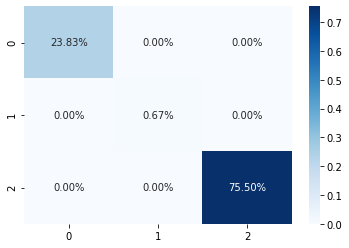

In [98]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [101]:
print(y_pred.unique())

['pellets' 'chip' 'lump']
